In [1]:
import csv
import numpy as np
import multiprocessing as mp
import random
import matplotlib.pyplot as plt
import pickle
import pandas as pd
#import tensorflow as tf
import json
from sklearn.model_selection import train_test_split
import math

import warnings
warnings.filterwarnings('ignore')

In [2]:
data_dir='../data/Current Data/'

In [3]:
CategoricalFeatures=[]
NumericFeatures=[]

demographics

In [4]:
df_demographics=pd.read_csv(data_dir+'REACT_Demographics'+'.csv')
#df_demographics.info()

In [5]:
#df_demographics.head()

In [6]:
#df_demographics.columns

In [7]:
CategoricalFeatures+=['GENDER','ETHNIC_GROUP', 'SMOKING_HISTORY']
NumericFeatures+=['PATIENT_AGE']

In [8]:
studyid_data_dic=dict()
for studyid,age,gender,ethnic,smoking in df_demographics[['STUDY_ID','PATIENT_AGE','GENDER','ETHNIC_GROUP', 'SMOKING_HISTORY']].values:
    if age is not np.nan and gender is not np.nan and ethnic is not np.nan and smoking is not np.nan:
        if studyid not in studyid_data_dic:
            studyid_data_dic[studyid]=dict()
        studyid_data_dic[studyid]['PATIENT_AGE']=age
        studyid_data_dic[studyid]['GENDER']=str(gender)
        studyid_data_dic[studyid]['ETHNIC_GROUP']=ethnic
        studyid_data_dic[studyid]['SMOKING_HISTORY']=smoking
#studyid_data_dic

Comorbidities

In [9]:
df_comorbidities=pd.read_csv(data_dir+'REACT_Comorbidities_unpivoted'+'.csv')
#df_demographics.info()

In [10]:
comorbidities=list(df_comorbidities.COMORBIDITY.unique())
NumericFeatures+=comorbidities
for studyid in studyid_data_dic:
    for co in comorbidities:
        studyid_data_dic[studyid][co]=0

In [11]:
for studyid,co,status in df_comorbidities.values:
    if studyid in studyid_data_dic:
        studyid_data_dic[studyid][co]=status
#studyid_data_dic

label: RespiratorySupportRequired or not

In [12]:
df_event=pd.read_csv(data_dir+'REACT_Events'+'.csv')
#df_event.info()

In [13]:
#df_event.head()

In [14]:
df_label=df_event[df_event.EVENT_TYPE=='ITU'][['STUDY_ID','START_DATETIME','END_DATETIME']]

In [15]:
max_end_datetime=max([x for x in list(df_event.END_DATETIME.unique()) if x is not np.nan])
#max_end_datetime

In [16]:
from datetime import datetime

label_studyid_time_dic=dict()
for study_id,start_datetime,end_datetime in df_label.values:
    start_datetime=datetime.strptime(start_datetime,'%Y-%m-%d %H:%M:%S')
    end_datetime=datetime.strptime(end_datetime if end_datetime is not np.nan else max_end_datetime,'%Y-%m-%d %H:%M:%S')
    if study_id not in label_studyid_time_dic:
        label_studyid_time_dic[study_id]=[None,None]
    if label_studyid_time_dic[study_id][0] is None or label_studyid_time_dic[study_id][0]>start_datetime:
        label_studyid_time_dic[study_id][0]=start_datetime
    if label_studyid_time_dic[study_id][1] is None or label_studyid_time_dic[study_id][0]<end_datetime:
        label_studyid_time_dic[study_id][1]=end_datetime

#label_studyid_time_dic

In [17]:
for studyid in studyid_data_dic:
    if studyid not in label_studyid_time_dic:
        studyid_data_dic[studyid]['TIME_POINT']=None
        studyid_data_dic[studyid]['PREDICTION_LABEL']=0
    else:
        start_datetime,end_datetime=label_studyid_time_dic[studyid]
        studyid_data_dic[studyid]['TIME_POINT']=start_datetime
        studyid_data_dic[studyid]['PREDICTION_LABEL']=(end_datetime-start_datetime).days
#studyid_data_dic

labresults

In [18]:
df_labresults=pd.read_csv(data_dir+'REACT_LabResults'+'.csv')
#df_labresults.info()

In [19]:
#df_labresults.head()

In [20]:
testcode_lst=list(df_labresults.REACT_TESTCODE.unique())
testcode2id=dict([(testcode_lst[i],i) for i in range(len(testcode_lst))])

In [21]:
from datetime import datetime

studyid_testcode_time_numeric_dic=dict()
for studyid,test_time,testcode,numeric,lower,upper in df_labresults[[
    'STUDY_ID','PATHOLOGY_SPECIMEN_DATE','REACT_TESTCODE',
    'PATHOLOGY_RESULT_NUMERIC','LOWER_RANGE','UPPER_RANGE']].values:
    test_time=datetime.strptime(test_time,'%Y-%m-%d %H:%M:%S')
    if studyid not in studyid_testcode_time_numeric_dic:
        studyid_testcode_time_numeric_dic[studyid]=[]
    studyid_testcode_time_numeric_dic[studyid].append([test_time,testcode,numeric])
#studyid_testcode_time_numeric_dic

In [22]:
NumericFeatures+=[testcode+suffix for testcode in testcode_lst for suffix in ['_MIN','_MAX','_MEAN']]

In [23]:
for studyid in studyid_data_dic:
    for testcode in testcode_lst:
        for suffix in ['_MIN','_MAX','_MEAN']:
            studyid_data_dic[studyid][testcode+suffix]=None
    time_point=studyid_data_dic[studyid]['TIME_POINT']
    if studyid in studyid_testcode_time_numeric_dic:
        individual_labresult_dic=dict()
        for test_time,testcode,numeric in studyid_testcode_time_numeric_dic[studyid]:
            if time_point is None or test_time<time_point:
                if testcode not in individual_labresult_dic:
                    individual_labresult_dic[testcode]=[]
                individual_labresult_dic[testcode].append(numeric)
        for testcode in individual_labresult_dic:
            studyid_data_dic[studyid][testcode+'_MIN']=np.min(individual_labresult_dic[testcode])
            studyid_data_dic[studyid][testcode+'_MAX']=np.min(individual_labresult_dic[testcode])
            studyid_data_dic[studyid][testcode+'_MEAN']=np.mean(individual_labresult_dic[testcode])

data preprocessing

In [24]:
studyid_lst=list(studyid_data_dic.keys())
#studyid_lst

In [25]:
X_cols=[]

In [26]:
from sklearn.preprocessing import OneHotEncoder

X_categorical=[[studyid_data_dic[studyid][k] for k in CategoricalFeatures] for studyid in studyid_lst]

enc = OneHotEncoder(handle_unknown='ignore')
X_onehot=enc.fit_transform(X_categorical).toarray()

X_cols+=list(enc.get_feature_names(CategoricalFeatures))

In [27]:
X_numeric=[[studyid_data_dic[studyid][k] for k in NumericFeatures] for studyid in studyid_lst]
X_cols+=NumericFeatures

In [28]:
X_missing_value=np.concatenate((X_onehot,X_numeric), axis=1)

In [29]:
Y=np.array([studyid_data_dic[studyid]['PREDICTION_LABEL'] for studyid in studyid_lst])

balance_ratio=len([_ for v in Y if v==0])/len([_ for v in Y if v==1])
balance_ratio

from functools import reduce

XY_missing_value_balanced=np.array(
    reduce(lambda a,b:a+b,[[list(x)+[y]]*(int(balance_ratio) if y==1 else 1) for x,y in zip(X_missing_value,Y)])
)

X_missing_value=XY_missing_value_balanced[:,:-1]
Y=np.array(XY_missing_value_balanced[:,-1],dtype=int)

fill in nan

In [30]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

X=imputer.fit_transform(X_missing_value)

Prediction Classification task (RespiratorySupportRequired:1 or not:0)

In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor

models={
    "Linear":LinearRegression(),
    "MLP":MLPRegressor(max_iter=3000,solver='adam', alpha=1e-3,hidden_layer_sizes=(64)),
    "DecisionTree":DecisionTreeRegressor(),
    "RandomForest":RandomForestRegressor(),
    "AdaBoost":AdaBoostRegressor(n_estimators=100),
    "GradientBoosting":GradientBoostingRegressor(),
    "XGBoost":XGBRegressor(n_estimators=100)
}

In [32]:
from sklearn.model_selection import KFold

from sklearn.metrics import r2_score,mean_squared_error

ap_result_lst=[]

kf = KFold(n_splits=10,shuffle=True)

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    ap_result_lst.append(
        [r2_score(y_test,models[model_name].fit(X_train,y_train).predict(X_test))\
                for model_name in models])

print(pd.DataFrame(ap_result_lst,columns=[model_name for model_name in models]))

     Linear        MLP  DecisionTree  RandomForest   AdaBoost  \
0  0.007251  -0.301780     -0.418146     -0.151656  -0.102488   
1 -0.078871  -1.417887     -0.121246      0.225927  -0.206326   
2 -0.054878  -1.529921     -0.423395     -0.054051   0.039155   
3 -1.591955  -5.842118     -5.009792     -2.340486 -46.105889   
4 -0.894184  -6.702101     -0.961770      0.155173  -8.584672   
5 -0.055300 -69.871485     -3.217092     -0.030855 -22.460842   
6  0.090065  -0.681941     -0.589105     -0.110142   0.093833   
7 -0.276574  -5.872055     -1.637932      0.030534  -6.738640   
8 -1.054719 -17.744517     -1.406071      0.144184  -1.587023   
9 -2.744517 -20.909348     -3.308618     -2.686833 -83.331887   

   GradientBoosting   XGBoost  
0         -0.111038 -0.244228  
1          0.140101 -0.573321  
2         -0.155498 -0.611250  
3         -2.619931 -3.279894  
4          0.219632  0.271628  
5          0.049503 -0.145125  
6          0.078125 -0.472231  
7          0.255898 -1.09220

In [33]:
print(pd.DataFrame(np.mean(ap_result_lst,axis=0,keepdims=True),columns=[model_name for model_name in models]))

     Linear        MLP  DecisionTree  RandomForest   AdaBoost  \
0 -0.665368 -13.087315     -1.709317     -0.481821 -16.898478   

   GradientBoosting   XGBoost  
0         -0.478006 -0.970824  


In [34]:
from sklearn.linear_model import LinearRegression

regr = LinearRegression().fit(X, Y)

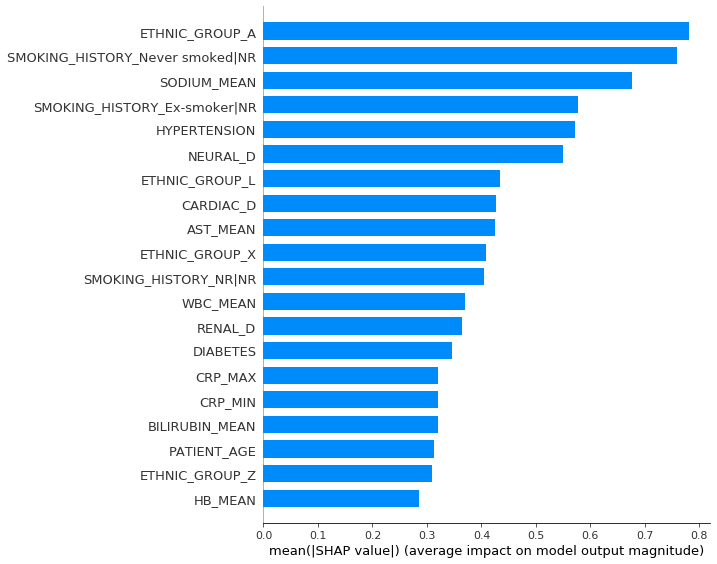

In [35]:
import shap

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.LinearExplainer(regr,X)
shap_values = explainer.shap_values(X)

# summarize the effects of all the features
shap.summary_plot(shap_values, X, feature_names=X_cols, plot_type="bar")

In [36]:
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor().fit(X, Y)

In [37]:
feature_importance_dic=dict(zip(X_cols,regr.feature_importances_))
from sklearn.feature_selection import SelectFromModel
for k,v in sorted(
    [(X_cols[i],feature_importance_dic[X_cols[i]]) for i in SelectFromModel(regr, prefit=True, max_features=20).get_support(indices=True)],
    key=lambda x:x[1],
    reverse=True
):
    print(k,':',v)

PATIENT_AGE : 0.20446405693080116
UREA_MEAN : 0.06905150832952386
HIV : 0.05519264921007
ETHNIC_GROUP_L : 0.04704011138463779
ETHNIC_GROUP_N : 0.030091853435839165
OBESITY : 0.027063260088490658
GENDER_2 : 0.02657699304295523
HYPERTENSION : 0.026470921362286334
CRP_MIN : 0.026220058011288364
ETHNIC_GROUP_G : 0.02602851225692347
NEURAL_D : 0.02467806965260447
SMOKING_HISTORY_NR|NR : 0.02350701396114103
CRP_MAX : 0.021582010074902187
COPD : 0.02150575307378104
GENDER_1 : 0.020101543592848672
UREA_MAX : 0.018902568179178344
UREA_MIN : 0.018254935603773056
CARDIAC_D : 0.01824776085605547
LIVER_D : 0.018197766760835107
SMOKING_HISTORY_Never smoked|NR : 0.01706020121237206


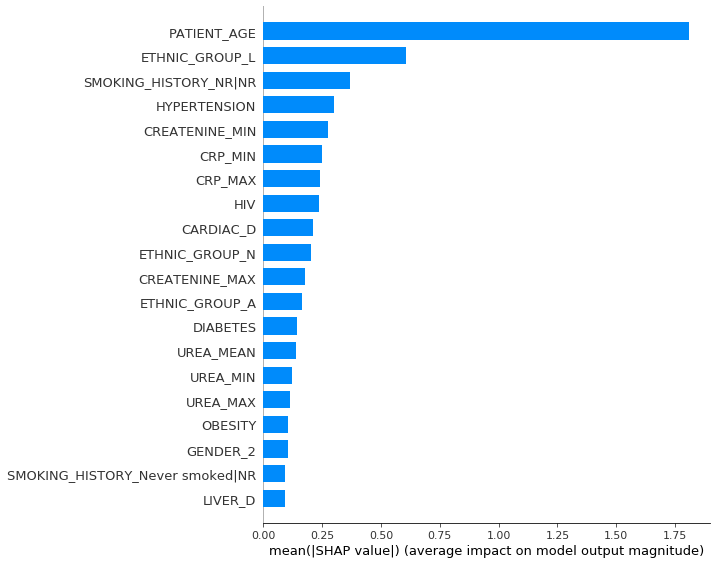

In [38]:
import shap

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(regr)
shap_values = explainer.shap_values(X)

# summarize the effects of all the features
shap.summary_plot(shap_values, X, feature_names=X_cols, plot_type="bar")

In [39]:
from sklearn.ensemble import GradientBoostingRegressor

regr = GradientBoostingRegressor().fit(X, Y)

In [40]:
feature_importance_dic=dict(zip(X_cols,regr.feature_importances_))
from sklearn.feature_selection import SelectFromModel
for k,v in sorted(
    [(X_cols[i],feature_importance_dic[X_cols[i]]) for i in SelectFromModel(regr, prefit=True, max_features=20).get_support(indices=True)],
    key=lambda x:x[1],
    reverse=True
):
    print(k,':',v)

UREA_MEAN : 0.21454732600667525
PATIENT_AGE : 0.18623181406112863
ETHNIC_GROUP_L : 0.08610165509100802
HIV : 0.07244377089856484
CRP_MAX : 0.06979219428796439
CRP_MIN : 0.05577776825852597
COPD : 0.050615978310434295
BILIRUBIN_MEAN : 0.032266593301817505
ETHNIC_GROUP_N : 0.03197430498883307
ETHNIC_GROUP_P : 0.010416181228689644
NEUTROPHILS_MEAN : 0.009784677223715342


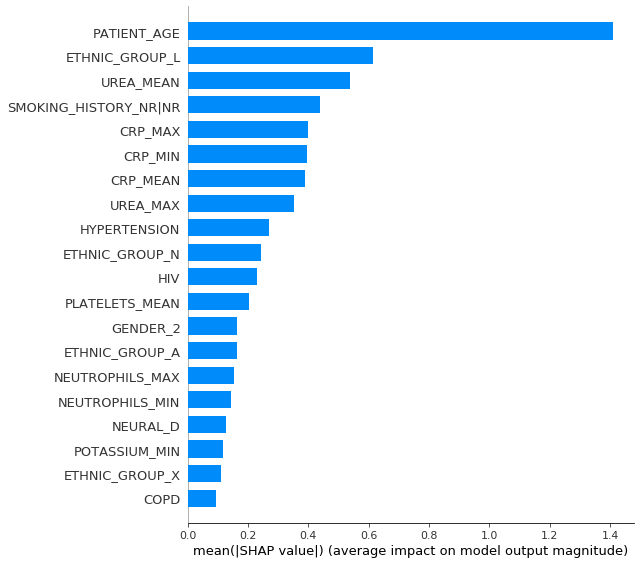

In [41]:
import shap

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(regr)
shap_values = explainer.shap_values(X)

# summarize the effects of all the features
shap.summary_plot(shap_values, X, feature_names=X_cols, plot_type="bar")

In [42]:
from xgboost import XGBRegressor

regr=XGBRegressor(n_estimators=100).fit(X,Y)

In [43]:
feature_importance_dic=dict(zip(X_cols,regr.feature_importances_))
from sklearn.feature_selection import SelectFromModel
for k,v in sorted(
    [(X_cols[i],feature_importance_dic[X_cols[i]]) for i in SelectFromModel(regr, prefit=True, max_features=20).get_support(indices=True)],
    key=lambda x:x[1],
    reverse=True
):
    print(k,':',v)

UREA_MEAN : 0.15637402
HIV : 0.110313766
SODIUM_MEAN : 0.09505556
BILIRUBIN_MIN : 0.056845937
CRP_MIN : 0.05515346
ETHNIC_GROUP_P : 0.045910727
ETHNIC_GROUP_L : 0.043996733
COPD : 0.037465382
CREATENINE_MIN : 0.033353895
LIVER_D : 0.023989711
ETHNIC_GROUP_N : 0.023566252
PATIENT_AGE : 0.018748188
CRP_MEAN : 0.017426418
HYPERTENSION : 0.01690989
SMOKING_HISTORY_NR|NR : 0.016071811
NEUTROPHILS_MIN : 0.016051447
OBESITY : 0.01592517
HB_MIN : 0.015263664
CARDIAC_D : 0.013468906
RENAL_D : 0.011408911
